# Progetto del corso di Quantum Computing

## Caso base: immagine 4x4px

Iniziamo la trattazione con l'implementazione dell'algoritmo di base, nel caso di un'immagine $2^2 \times 2^2$ pixel.

### Import section

In [51]:
import numpy as np
from math import pi

# Grafici
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
style.use('bmh')

L'immagine è volutamente dotata di repentini cambi verticali di intensità ogni 4 righe.

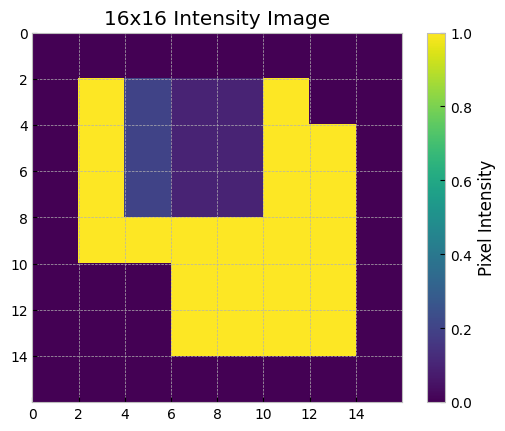

In [52]:
# #A 16x16 image with marked rows
# image = np.array([
#     [(i % 4) * 0.25 for j in range(16)]
#     for i in range(16)
# ])

# A 8x8 binary image
image = np.array([[0, 0, 0, 0, 0, 0, 0, 0],
                  [0, 1, 0.2, 0.1, 0.1, 1, 0, 0],
                  [0, 1, 0.2, 0.1, 0.1, 1, 1, 0],
                  [0, 1, 0.2, 0.1, 0.1, 1, 1, 0],
                  [0, 1, 1, 1, 1, 1, 1, 0],
                  [0, 0, 0, 1, 1, 1, 1, 0],
                  [0, 0, 0, 1, 1, 1, 1, 0],
                  [0, 0, 0, 0, 0, 0, 0, 0]])

# Duplicare ogni elemento in un blocco 2x2 per ottenere un'immagine 16x16
image = np.kron(image, np.ones((2, 2)))


# Function for plotting the image using matplotlib
def plot_image(img, title: str):
    plt.title(title)
    plt.xticks(range(0, img.shape[0], 2))  # Show ticks every 2 pixels for clarity
    plt.yticks(range(0, img.shape[1], 2))
    plt.imshow(img, extent=[0, img.shape[0], img.shape[1], 0], cmap='viridis')
    plt.colorbar(label="Pixel Intensity")
    plt.show()
    
plot_image(image, '16x16 Intensity Image')

Utilizziamo ora la _Quantum Probability Image Encoding_ (QPIE) per codificare le intensità dei pixel:

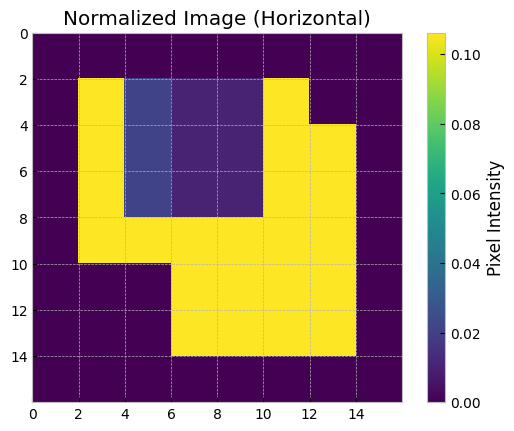

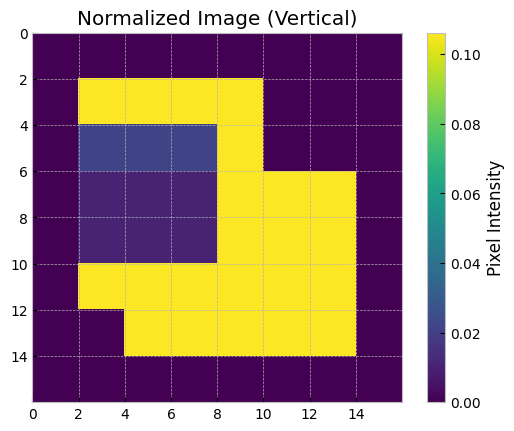

In [53]:
# Convert the raw pixel values to probability amplitudes
def amplitude_encode(img_data):
    
    # Calculate the RMS value
    rms = np.sqrt(np.sum(np.sum(img_data**2, axis=1)))
    
    # Create normalized image
    image_norm = []
    for arr in img_data:
        for ele in arr:
            image_norm.append(ele / rms)
        
    # Return the normalized image as a numpy array
    return np.array(image_norm)

# Get the amplitude ancoded pixel values
# Horizontal: Original image
image_norm_h = amplitude_encode(image)

# Vertical: Transpose of Original image
image_norm_v = amplitude_encode(image.T)

plot_image(image_norm_h.reshape(16, 16), 'Normalized Image (Horizontal)')
plot_image(image_norm_v.reshape(16, 16), 'Normalized Image (Vertical)')

In [54]:
# Initialize some global variable for number of qubits
data_qb = 8
anc_qb = 1
total_qb = data_qb + anc_qb

# Initialize the amplitude permutation unitary
D2n_1 = np.roll(np.identity(2**total_qb), 1, axis=1)
print(D2n_1)

[[0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 [1. 0. 0. ... 0. 0. 0.]]


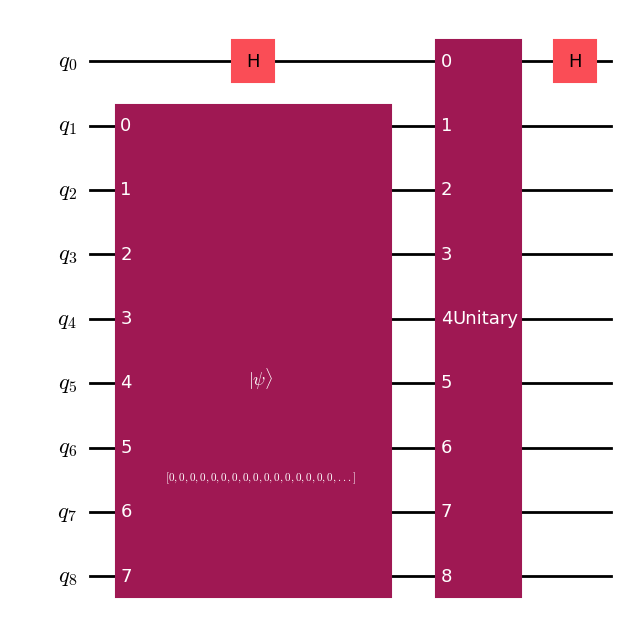

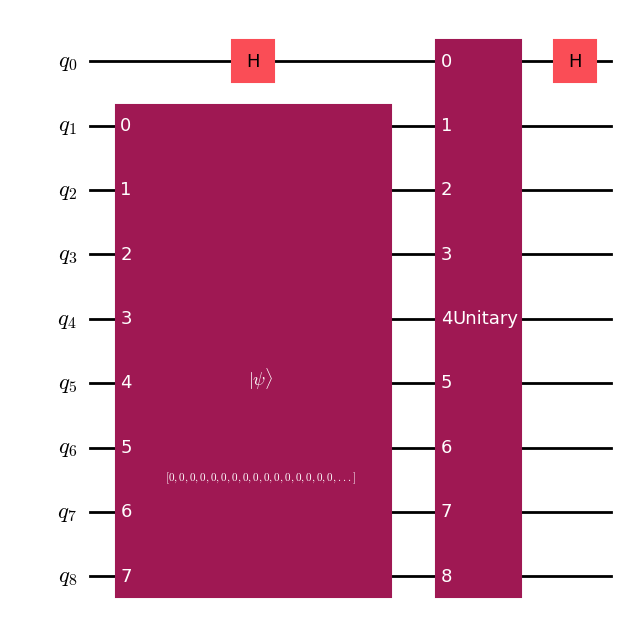

In [55]:
from qiskit import *
from qiskit_aer import Aer


# Create the circuit for horizontal scan
qc_h = QuantumCircuit(total_qb)
qc_h.initialize(image_norm_h, range(1, total_qb))
qc_h.h(0)
qc_h.unitary(D2n_1, range(total_qb))
qc_h.h(0)
display(qc_h.draw('mpl', fold=-1))

# Create the circuit for vertical scan
qc_v = QuantumCircuit(total_qb)
qc_v.initialize(image_norm_v, range(1, total_qb))
qc_v.h(0)
qc_v.unitary(D2n_1, range(total_qb))
qc_v.h(0)
display(qc_v.draw('mpl', fold=-1))

# Combine both circuits into a single list
circ_list = [qc_h, qc_v]

In [56]:
# Simulating the circuits
backend = Aer.get_backend('statevector_simulator')
new_circuit = transpile(circ_list, backend)

# Stampa dei circuiti dopo il transpile
# for idx, circuit in enumerate(new_circuit):
#     print(f"Circuito {idx + 1} dopo il transpiling:")
#     print(circuit.draw())

result = backend.run(new_circuit).result()
sv_h = np.array(result.get_statevector(qc_h))
sv_v = np.array(result.get_statevector(qc_v))

from qiskit.visualization import array_to_latex
print('Horizontal scan statevector:')
print(sv_h[:64])
#display(array_to_latex(sv_h[:30], max_size=30))
print()
print('Vertical scan statevector:')
print(sv_v[:64])
#display(array_to_latex(sv_v[:30], max_size=30))

Horizontal scan statevector:
[0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j
 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j
 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j
 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j
 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j
 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j
 0.+0.j 0.+0.j 0.+0.j 0.+0.j]

Vertical scan statevector:
[0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j
 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j
 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j
 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j
 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j
 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j
 0.+0.j 0.+0.j 0.+0.j 0.+0.j]


[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 1 0 0 0 0 0 0 1 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 1 1 1 1 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 1 1 1 1 1 1 1 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]


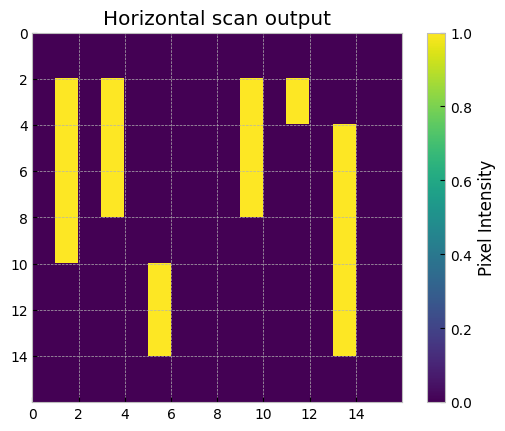

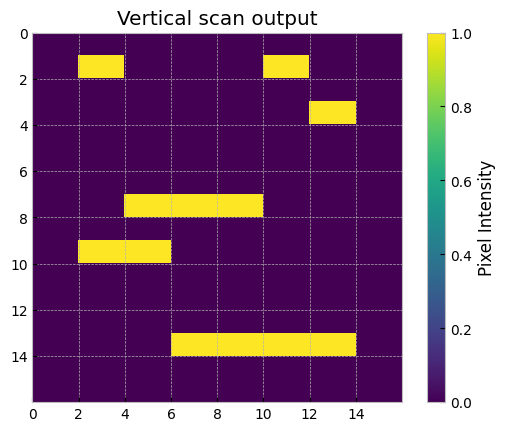

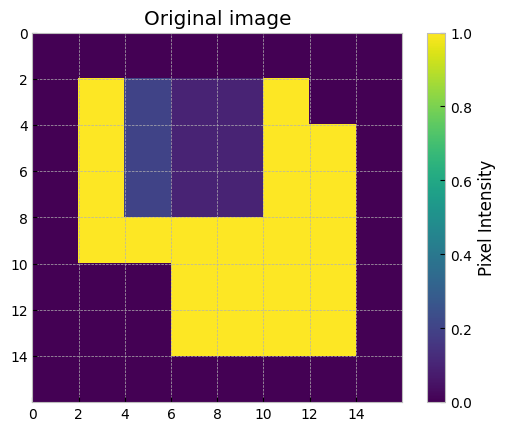

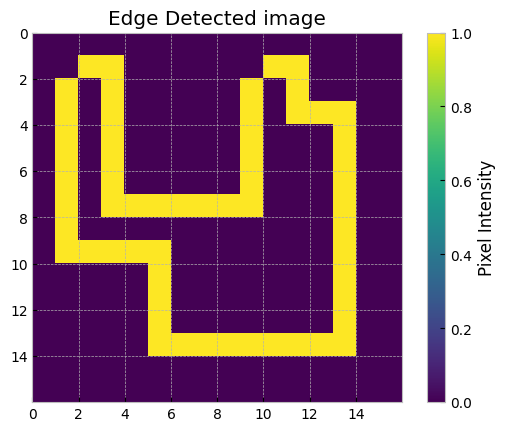

In [57]:
# Classical postprocessing for plotting the output

# Defining a lambda function for
# thresholding to binary values
bound=4e-02
threshold = lambda amp: (amp > bound or amp < -bound)

# Selecting odd states from the raw statevector and
# reshaping column vector of size 64 to an 8x8 matrix
edge_scan_h = np.abs(np.array([1 if threshold(sv_h[2*i+1].real) else 0 for i in range(2**data_qb)])).reshape(16, 16)
edge_scan_v = np.abs(np.array([1 if threshold(sv_v[2*i+1].real) else 0 for i in range(2**data_qb)])).reshape(16, 16).T

print(edge_scan_v)

# Plotting the Horizontal and vertical scans
plot_image(edge_scan_h, 'Horizontal scan output')
plot_image(edge_scan_v, 'Vertical scan output')

# Combining the horizontal and vertical component of the result
edge_scan_sim = edge_scan_h | edge_scan_v

# Plotting the original and edge-detected images
plot_image(image, 'Original image')
plot_image(edge_scan_sim, 'Edge Detected image')